## Building hail damage data
#### This notebook shows the code to visualize building damage and exposure data

In [1]:
#Load packages
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd 
import xarray as xr
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patheffects as patheffects
import datetime as dt
import dask
import colorcet as cc
from climada import util
from rasterio.warp import reproject, Resampling, calculate_default_transform
import geopandas as gpd
from climada.entity import Entity, Exposures
from climada.hazard import Hazard,Centroids
from scipy import sparse, optimize
import timeit
from scipy.ndimage import gaussian_filter as g_filter
import cartopy.crs as ccrs
import cartopy.feature as cf
from climada.entity import ImpactFunc, ImpactFuncSet
from climada.engine import Impact, ImpactCalc
from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim.hail_climada as fct
import scClim as sc
from scClim.constants import CH_EXTENT,ZRH_EXTENT,ZRH_EXTENT_EPSG2056,SUB_CH_EXTENT_2056
SUB_CH_EXTENT_2056_tight = (2550000.0, 2720000.0, 1130000.0, 1280000.0) # default: (2550000.0, 2750000.0, 1125000.0, 1290000.0)

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)
event_def_version=7

Could not find bayes_opt. Module Calib_opt will not work.


In [2]:
#Load building damage dataset (KGV=Kantonale Gebäudeversicherungen)
ds_KGV = xr.open_dataset(data_dir+'/KGV/ds_building_dmg_v7_1000m_wModImp.nc')
ds_KGV = ds_KGV.rename({'value':'imp_observed'})
ds_KGV['PAA_MESHS'] = ds_KGV.n_buildings_MESHS/ds_KGV.n_count_exposure
ds_KGV['PAA_crowd'] = ds_KGV.n_buildings_crowd/ds_KGV.n_count_exposure

## Exposure data plot

In [4]:
#define plotting defaults and functions
pl_kwargs = {'extent':SUB_CH_EXTENT_2056,'crs':'EPSG:2056','borders':False,'cbar_horizontal':True}
def add_plot_features(ax):
    sc.plot_canton(ax=ax,canton=['Zürich','Bern','Luzern','Aargau'],zorder=2,lakeEdgeColor='k')
    gl=ax.gridlines(draw_labels=["top","right"], x_inline=False, y_inline=False,linestyle='--',
                    xlabel_style={'color':'grey'},ylabel_style={'color':'grey'})
    sc.plot_funcs.scale_bar(ax,point=(0.7,0.07),length=50e3,line_kwargs={'linewidth':3})    

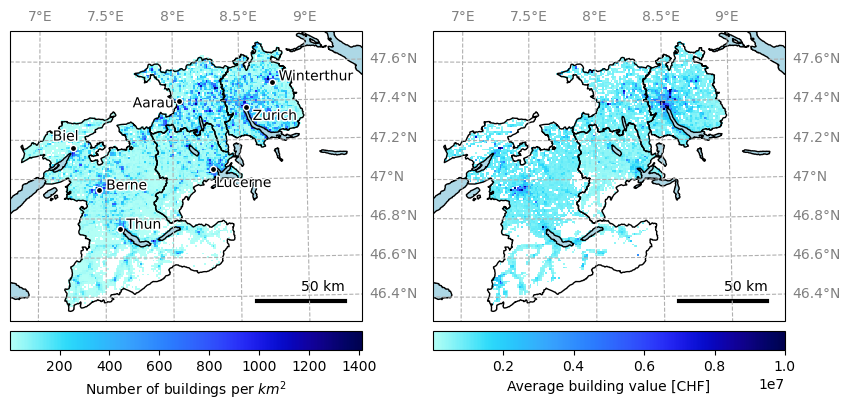

In [5]:
avg_value = (ds_KGV.value_exposure/ds_KGV.n_count_exposure).where(ds_KGV.n_count_exposure>10)

#set up figure
fig,axes = plt.subplots(1,2,subplot_kw={'projection':ccrs.epsg(2056)},figsize=(10,5))
for ax,title,imp_var,label,vMinMax in zip(axes,['Number of buildings per $km^2$','Average building value [CHF]'],
                                  [ds_KGV.n_count_exposure,avg_value],['(a)','(b)'],[(1,None),(1,1e7)]):
    sc.plot_nc(imp_var,vmin=vMinMax[0],vmax=vMinMax[1],ax=ax,#vmax=2000,
            logScale=False,cmap=cc.cm.kbc_r,cbar_lbl=title,**pl_kwargs)
    add_plot_features(ax)
        #add cities
    if label == '(a)':
        for name,coords,coords_txt in zip(['Zurich','Berne','Lucerne','Aarau','Winterthur','Biel','Thun'],
                            [(8.55,47.366),(7.45,46.95),(8.3,47.05),(8.05,47.4),(8.75,47.49),(7.25,47.16),(7.6,46.75)],
                            [(8.6,47.3),(7.5,46.95),(8.32,46.96),(7.7,47.37),(8.8,47.5),(7.1,47.2),(7.65,46.75)]):
            ax.annotate(name,coords,xytext=coords_txt,xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                        path_effects=[patheffects.withStroke(linewidth=2, foreground='white')])
            ax.scatter(coords[0],coords[1],transform=ccrs.PlateCarree(),s=20,marker='o',color='black',edgecolor='white',zorder=3)
fig.savefig(out_dir+'/paper1/fig02.png',dpi=300,bbox_inches='tight')

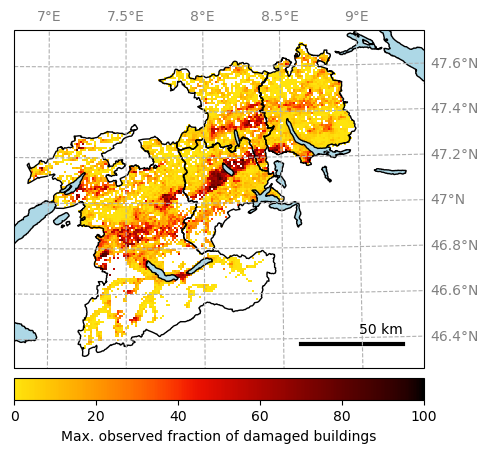

In [6]:
cmap = sc.plot_cmaps.truncate_colormap(cc.cm.fire_r,0.1,1)
cmap.set_under('white',alpha=0)
max_PAA = ds_KGV.where(ds_KGV.n_count_exposure>=10).PAA.max(dim=('date'))*100
ax = sc.plot_nc(max_PAA,cmap=cmap,cbar_lbl='Max. observed fraction of damaged buildings',vmax=100,**pl_kwargs)
add_plot_features(ax)
fig = ax.get_figure()
fig.savefig(out_dir+'/paper1/PAA_max.png',dpi=300,bbox_inches='tight')

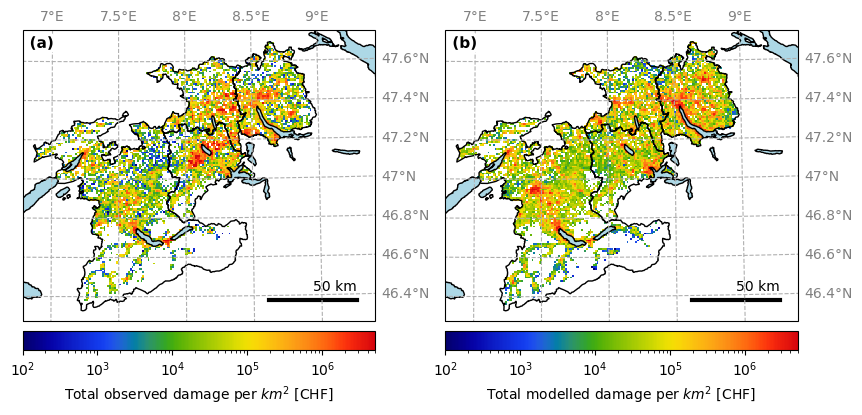

In [7]:
cmap = sc.plot_cmaps.truncate_colormap(cc.cm.rainbow4,0.0,1)
fig,axes = plt.subplots(1,2,subplot_kw={'projection':ccrs.epsg(2056)},figsize=(10,5))
for ax,title,imp_var,label in zip(axes,['observed','modelled'],['imp_observed','imp_MESHS'],['(a)','(b)']):
    AAI = ds_KGV.where(ds_KGV.n_count_exposure>=10)[imp_var].sum(dim=('date'))
    ax = sc.plot_nc(AAI,cmap=cmap,ax=ax,cbar_lbl=f'Total {title} damage per $km^2$ [CHF]',
                    vmin=100,vmax=5000000,logScale=True,**pl_kwargs)
    add_plot_features(ax)
    txt = ax.text(0.02,0.98,label,transform=ax.transAxes,fontsize=11,fontweight='bold',ha='left',va='top')
    txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
fig.savefig(out_dir+'/paper1/fig11.png',dpi=300,bbox_inches='tight')


## Per building damages

"linear" fit in log space-> powerlaw with exponent=0.27


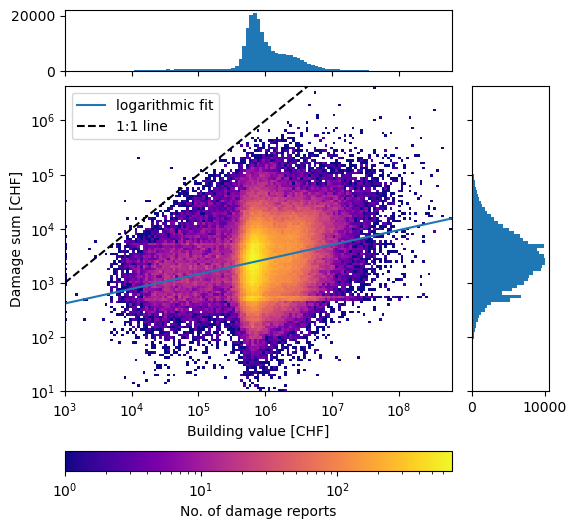

In [5]:
from matplotlib import colors
dmg_gdf_save = pd.read_csv(f'{data_dir}/KGV/KGV_Hail_Loss_date_corrected{event_def_version}.csv',sep=';',index_col=0)

x_var = 'Versicherungssumme'
x_log=True
y_var = 'Schadensumme' #'rel_dmg'
y_log=True

x_vals = np.log10(dmg_gdf_save[x_var]) if x_log else dmg_gdf_save[x_var]
x_lab = x_var +' (log10)' if x_log else x_var

y_vals = np.log10(dmg_gdf_save[y_var]) if y_log else dmg_gdf_save[y_var]
y_lab = y_var +' (log10)' if y_log else y_var

nans = (x_vals.isna()) | (y_vals.isna())
if any(nans):
    print(f'Warning: {nans.sum()} Nan values are removed {nans.sum()/len(nans)*100:.1f}%')
    x_vals = x_vals[~nans]
    y_vals = y_vals[~nans]
    
fig,ax=plt.subplots(figsize=(5,5))

p=ax.hist2d(x_vals, y_vals,cmap = plt.cm.get_cmap('plasma'),
          bins=160,norm=colors.LogNorm(),cmin=1)
sc.add_cbar(ax,p[3],cbar_lbl='No. of damage reports',horizontal=True,pad=0.6)
ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax_histx.hist(x_vals, bins=120,)
ax_histy.hist(y_vals, bins=120, orientation='horizontal')

ax.set(xlim=[3,None],ylim=[1,None],
       xlabel='Building value [CHF]',ylabel='Damage sum [CHF]',
       xticks=np.arange(3,8+1),xticklabels=[f'$10^{i}$' for i in np.arange(3,8+1)],
        yticks=np.arange(1,6+1),yticklabels=[f'$10^{i}$' for i in np.arange(1,6+1)])
fit = np.polyfit(x_vals, y_vals, deg=1)
x_arr=np.linspace(min(x_vals),max(x_vals),100)
y_fit = fit[0]*x_arr+fit[1]
print('"linear" fit in log space-> powerlaw with exponent=%.2f'%fit[0])
ax.plot(x_arr,y_fit,color='tab:blue',label='logarithmic fit')
ax.axline((1e4,1e4),slope=1,color='black',linestyle='--',label='1:1 line')
ax.legend(loc='upper left',bbox_to_anchor=(0,1))
fig.savefig(out_dir+'/paper1/fig03.png',dpi=300,bbox_inches='tight')

## Plotting events

In [8]:
# %% plot dmg events
years = np.arange(2002,2021+1)
meshs_paths = sc.E.get_hazard_files_TS('MESHS',years,event_def_version,data_dir)
meshs=xr.open_mfdataset(meshs_paths, concat_dim = 'time',combine='nested',coords = 'minimal')
dBZ_paths = sc.E.get_hazard_files_TS('dBZ',years,event_def_version,data_dir)
dBZ=xr.open_mfdataset(dBZ_paths, concat_dim = 'time',combine='nested',coords = 'minimal')
# E_kin = 

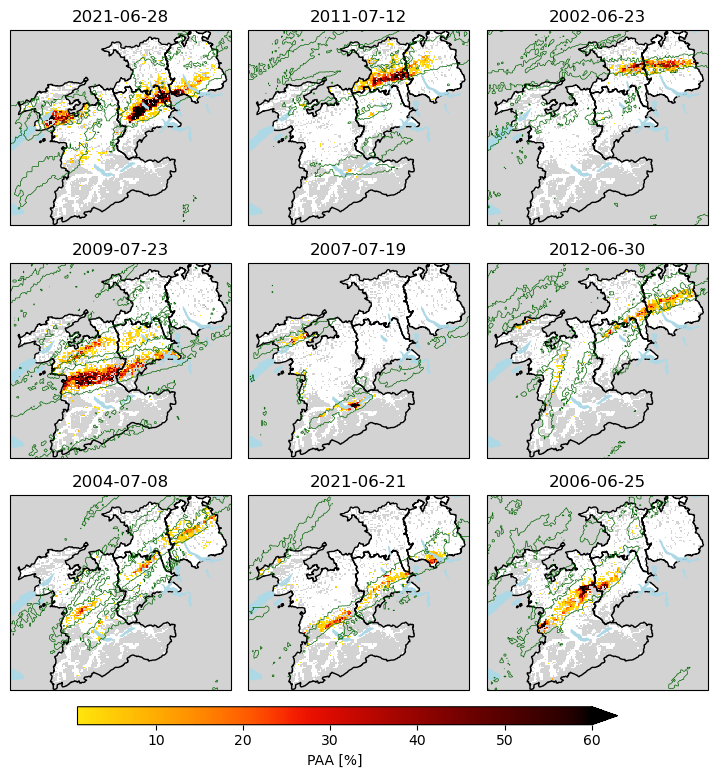

In [10]:
#define plotting parameters 
levels = [20]; colors=['darkgreen']
order = np.flip(ds_KGV.imp_observed.sum(dim=('chx','chy')).values.argsort())
min_exp_count = 10
vmax=60
pl_kwargs = {'extent':SUB_CH_EXTENT_2056_tight,'crs':'EPSG:2056','borders':False}
pl_kwargs_contour = {**pl_kwargs,'linewidths':0.5}

#set up figure
fig,axes = plt.subplots(3,3,figsize=(9,9),subplot_kw={'projection': ccrs.epsg(2056)},
                        gridspec_kw={'hspace':0.02,'wspace':0.08})
axes = axes.flatten()

#plot the 9 largest events
for i,ind in enumerate(order[:len(axes)]):
    date_dt = pd.to_datetime(ds_KGV.date[ind].values)
    ax,plot= sc.plot_funcs.plot_nc(ds_KGV.sel(date=date_dt)['PAA']*100,ax=axes[i],
                                cmap=sc.plot_cmaps.CMAP_IMPACT_CC,vmin=1,vmax=vmax,
                                cbar=False,return_plot=True,**pl_kwargs)
    exp_count=ds_KGV.sel(date=date_dt)['n_count_exposure']; density=6

    #grey out areas without enough exposure
    sc.plot_funcs.plot_nc(exp_count.fillna(0)<min_exp_count,ax=axes[i],
                        pl_type='bool_field',cmap='lightgrey',**pl_kwargs)
    sc.plot_canton(axes[i],canton=['Bern','Luzern','Zürich','Aargau'],edgecolor='black',
                        lakes=True,zorder=2)
    sc.plot_funcs.plot_nc(meshs.sel(time=date_dt).MZC.fillna(0),ax=axes[i],pl_type='contour',
                        levels=levels,colors=colors,**pl_kwargs_contour)
    axes[i].set_title(date_dt.strftime('%Y-%m-%d'))

#add colorbar
cax = fig.add_axes([0.2, 0.09, 0.6, 0.02]) #left, bottom, width, height
plt.colorbar(plot,cax = cax,orientation='horizontal',extend='max').set_label(f"PAA [%]")

fig.savefig(out_dir+'/paper1/figA1.png',dpi=300,bbox_inches='tight')